CIFAR-10 CNN
========

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 600000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 casses com 6000 imagens por classe. 

O exemplo abaixo é uma adaptação do exemplo fornecido na documentação do Keras: 
https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py

No exemplo uma rede convolucional profunda é treinada. A perda logaritmica no conjunto de teste chega a 0.65 em 25 épocas e a 0.55 após 50 épocas.

Para mostrar os pesos da rede vonvolucional: https://github.com/fchollet/keras/issues/431
https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb

Carregando e  mostrando os dados
==================


X_train shape: (50000, 3, 32, 32)
50000 amostras de treinamento
10000 amostras de teste


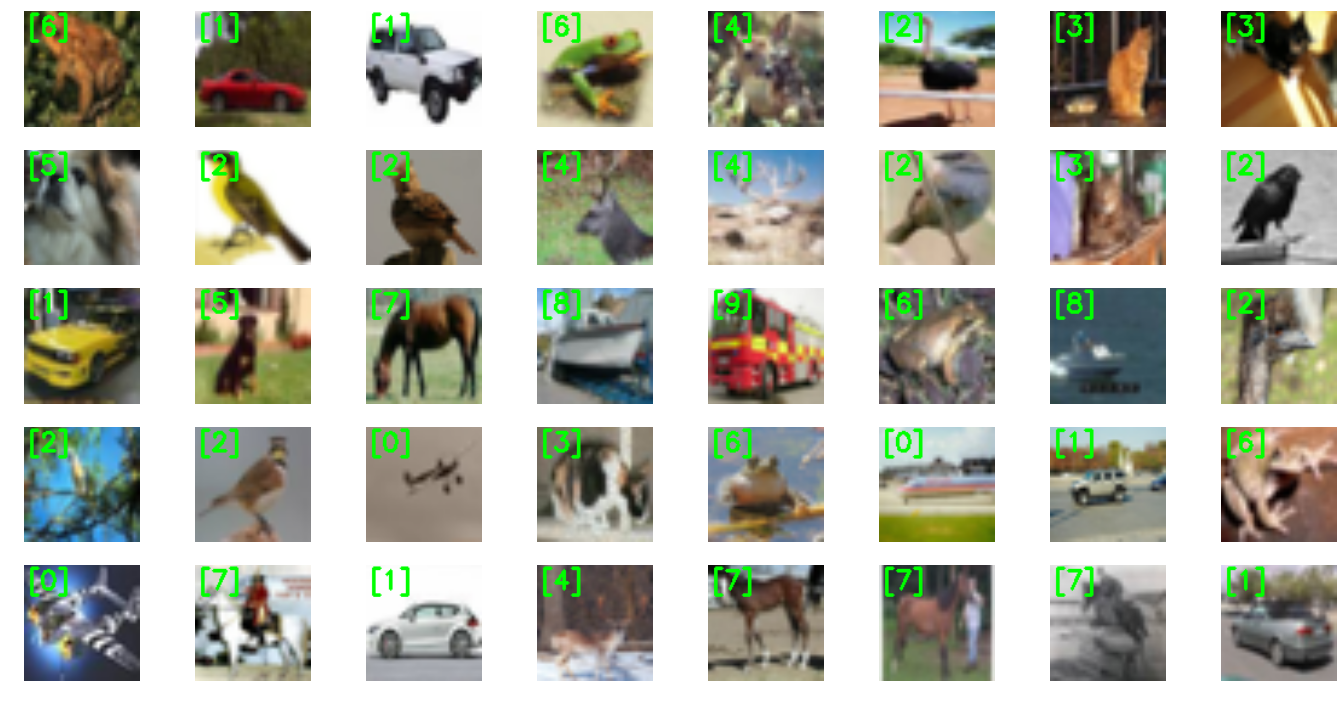

In [50]:
%matplotlib inline
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pylab as plt
import cv2
import numpy as np

batch_size = 32
nb_classes = 10
nb_epoch = 2 #00
data_augmentation = True

# Dimnesões das imagens
img_rows, img_cols = 32, 32
# Imagens RGB.
img_channels = 3

# varregando os dados
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

#Mostrando algumas imagens do conjunto de teste
plt.figure(figsize=(24, 12))
for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(40,))):
    plt.subplot(5, 8, k + 1)
    image = (X_test[i]).transpose(1,2,0)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(y_test[i]), (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
                (0, 255, 0), 2)

    # mostra as imagens
    plt.imshow(image)
    plt.axis('off')
    
# Transforma o vetor de labes para o formato de one-hot encoding.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Construíndo a CNN com o Keras
==============================

In [51]:
#Modelo sequencial
model = Sequential()

# Primeira convolução
conv1 = Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=X_train.shape[1:])
model.add(conv1)
convout1 = Activation('relu') 
model.add(convout1)


#Segunda convolução
model.add(Convolution2D(32, 3, 3))
convout2 = Activation('relu')
model.add(convout2)

# Primeiro Max-pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
maxpooling_out1 = Dropout(0.25)
model.add(maxpooling_out1)

# Terceira convolução
model.add(Convolution2D(64, 3, 3, border_mode='same'))
convout3 = Activation('relu') 
model.add(convout3)

# Quarta convolução
model.add(Convolution2D(64, 3, 3))
convout4 = Activation('relu') 
model.add(convout4)

# Segundo max-pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
maxpooling_out2 = Dropout(0.25)
model.add(maxpooling_out2)

# Camadas finais
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

if not data_augmentation:
    print('Sem aumento de dados.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Com aumento de dados.')
    # Pre-processamento e aumento de dados em tempo real:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # poe a media da entrada em 0 ao longo do dataset
        samplewise_center=False,  # poe a media de cada amostra em zero
        featurewise_std_normalization=False,  # normaliza pelo desvio padrão do dataset
        samplewise_std_normalization=False,  # normaliza pelo desvio padrão cada amostra
        zca_whitening=False,  # aplica "ZCA whitening"
        rotation_range=0,  # rotaciona as imagens aleatoriamente (0 a 180 graus)
        width_shift_range=0.1,  # aleatoriamente desloca a imagem horizontalmente (fração da largura)
        height_shift_range=0.1,  # aleatoriamente desloca a imagem certicalmente (fração da altura)
        horizontal_flip=True,  # espelha aleatoriamente as imagens na horizontal
        vertical_flip=False)  # espelha aleatoriamente as imagens na vertical

    # Cálcula os valores necessários para realizar a normalização por amostra
    # (desvio-padrão, Média, e componentes principais se for aplicado "ZCA whitening").
    datagen.fit(X_train)

    # Faz o treino do modelo nos batches gerados pelo datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train,
                                     batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
validation_data=(X_test, Y_test))

Com aumento de dados.
Epoch 1/2
50000/50000 [==============================] - 170s - loss: 1.6017 - acc: 0.4150 - val_loss: 1.1459 - val_acc: 0.5816
Epoch 2/2
50000/50000 [==============================] - 173s - loss: 1.2621 - acc: 0.5535 - val_loss: 1.0276 - val_acc: 0.6380


In [81]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = np.zeros((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [82]:
weights = conv1.get_weights()[0]
weightsR = weights[:,0,:,:]
weightsG = weights[:,1,:,:]
weightsB = weights[:,2,:,:]
#print(make_mosaic(weightsR, 3, 3, border=1).shape)
#for jj in xrange(32):
#    plt.imshow(weightsR[jj], cmap='gray')
#    plt.show()
    
plt.imshow(make_mosaic(weightsR, 3, 3, border=1))
plt.show()

ValueError: could not broadcast input array from shape (3,3) into shape (0,3)

In [42]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
